# Aprendizaje de Máquinas (Machine Learning)
## Clase 2: Modelado de problemas de Machine Learning

### 1. Configuración del ambiente

Antes que empezar a trabajar, vamos a preparar el ambiente.
Para ello:
* Instalamos todos los paquetes que vamos a necesitar para trabajar. Lo hacemos utilizando el controlador de paquetes de Python ```pip```. Cada vez que usemos ```!```en la consola, le estamos diciendo al notebook que ejecute la instrucción en la consola del sistema, no en la de Python.
* Montamos Google Drive para guardar allí los archivos que descarguemos. En la consola nos va a aparecer una solicitud para hacer clic en una URL, loggearnos con nuestra cuenta de Google y colocar un código de autorización en una casilla.

In [ ]:
# instalamos el paquete para descargar archivos
!pip install wget

# montar la unidad de google drive
from google.colab import drive
drive.mount('/content/gdrive/')

from os import makedirs
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/'
makedirs(datasets_folder, exist_ok=True)

# importo numpy
import numpy as np
np.set_printoptions(precision=3, suppress=True) # y hago un truco para imprimir solamente 3 decimales

# importo una librería para utilizar valores aleatorios
import random
random.seed(10)
np.random.seed(10)

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=a07eeef4f6dba5811682e5ef6af1201c80fe955db52d7f6b1b553571518f18a2
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Mounted at /content/gdrive/


### 2. Acceso a datos de la clase pasada

Vamos a trabajar con la partición en datos de entrenamiento, validación y test que preparamos en la clase anterior. Si el archivo no está disponible en Google Drive, volvé al Colab de la Clase 1 y ejecutá todos los bloques de código.

In [ ]:
# establecemos la ruta al archivo (si la cambiaron la clase pasada, corregir por
# la ruta correcta)
dataset_filename = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/housing_dataset_partitioned.pkl'

# cargamos los datos preparados
import pickle
with open(dataset_filename, 'rb') as f:
    dataset = pickle.load(f)
# verificamos si los datos están bien cargados
print('Variables in dataset object: {}'.format(dataset.keys()))

Variables in dataset object: dict_keys(['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test', 'feature_labels', 'mu', 'sigma'])


### 3. Entrenando nuestro primer modelo

Vamos a tomar como primer ejemplo un problema de regresión, utilizando los datos que preparamos en la clase anterior.

El problema que plantearemos es el de predecir la mediana de precio de una propiedad (en miles de dólares) en función de sus características. Se trata de un problema de regresión debido a que la variable objetivo $y$ (el precio de la propiedad) es una variable contínua.

Para entrenar un modelo necesitamos datos de entrenamiento. En nuestro caso, utilizaremos el conjunto $X_\text{train}$ y sus anotaciones $y_\text{train}$, que preparamos la clase pasada. Recordemos que esos datos ya fueron particionados representativamente, estás estandarizados de acuerdo a su media y desvío y fueron corregidos previamente para eliminar potenciales sesgos.

El modelo que utilizaremos es un modelo de regresión lineal regularizado, conocido como [Ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization). No se preocupen por los detalles, los vamos a ver la próxima clase. Lo que sí tenemos que saber ahora es que este modelo es capaz de resolver un problema de regresión lineal, y que tiene un hiperparámetro que usualmente se llama $\lambda$, pero que en Sklearn se denota con $\alpha$, que controla el nivel de regularización. La regularización es una estrategia matemática que se utiliza durante el entrenamiento para evitar el overfitting. Idealmente, su utilización nos permite mejorar la capacidad de generalización del modelo. Sin embargo, a veces puede ocurrir que la utilicemos y que los resultados no mejoren.

Haremos un primer entrenamiento del modelo utilizando un parámetro $\alpha=0$ (lo que equivale a usar un modelo de regresión lineal tradicional, sin regularización). 



In [ ]:
from sklearn.linear_model import Ridge

# creamos el objeto Ridge, que modela el método de Ridge regression
# - alpha: el parámetro de regularización
# - fit_intercept: por ahora no nos interesa, dejémoslo en True
model = Ridge(alpha=0.0, fit_intercept=True)
# lo fitteamos (entrenamos) con nuestros datos de entrenamiento
model.fit(dataset['X_train'], dataset['y_train'])

Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Listo! El modelo ya está entrenado. Internamente, la función .fit() ha encontrado la configuración óptima de parámetros para minimizar el error cuadrático medio sobre los datos de entrenamiento. En un modelo de regresión lineal, los parámetros son coeficientes que multiplican a cada feature. La suma de los valores de las features ponderadas por estos coeficientes es lo que determina la predicción final.

Podemos visualizar los valores de los coeficientes aprendidos utilizando un gráfico de barras.

Coeficientes: [[-1.597  1.113  0.028  0.554 -3.049  3.769 -1.429 -3.426  2.469 -1.962
  -2.509]]


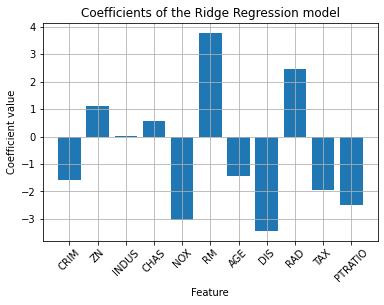

In [ ]:
# accedemos a los coeficientes del modelo
theta = model.coef_
# los imprimimos
print('Coeficientes: {}'.format(theta))

import matplotlib.pyplot as plt
plt.title('Coefficients of the Ridge Regression model')
plt.bar(np.arange(theta.size), np.squeeze(theta))
plt.xlabel('Feature')
plt.ylabel('Coefficient value')
plt.xticks(np.arange(theta.size), dataset['feature_labels'], rotation=45)
plt.grid(True)
plt.show()

Graficar los coeficientes permite de alguna manera "interpretar" qué hace el modelo que aprendimos. Pero eso lo veremos en detalle en la clase de regresión. Por lo pronto, observarlos nos permite ver que efectivamente el modelo está aprendiendo algo.

### 4. Validación

De nada nos sirve un modelo entrenado si no chequeamos qué tan efectivo es. Más aún porque no utilizamos regularización y no chequeamos si la necesitamos o no.

Lo próximo que haremos, entonces, es chequear **sobre los datos de validación** qué tan bueno es el modelo. No podemos usar los datos de test para esto, dado que, como dijimos antes, estos datos se usarán para explicar la performance del modelo final que elijamos (habiendo encontrado la configuración de $\alpha$ óptima para nuestros datos de entrenamiento/validación).

Para evaluar el modelo, primero necesitamos predecir los valores de variable objetivo, a los que llamaremos $\hat{y}$, para cada una de las muestras de los datos de validación. Lo hacemos utilizando el método .predict() de nuestro modelo.

In [ ]:
# usamos las features de los datos de validación para predecir la performance 
# sobre los datos de validación
y_hat_val = model.predict(dataset['X_val'])
# imprimimos la salida para las primeras 5 muestras
print('y_hat: {}'.format(y_hat_val[0:5]))
# e imprimimos la salida esperada
print('y: {}'.format(dataset['y_val'][0:5]))

y_hat: [[33.772]
 [30.687]
 [16.142]
 [20.3  ]
 [10.138]]
y: [[31.1]
 [31.5]
 [20. ]
 [50. ]
 [15. ]]


Ahora necesitamos evaluar cuantitativamente qué tan buenas son estas predicciones. Para ello utilizaremos una **métrica de evaluación**. 
Para evaluar problemas de regresión existen muchas. Nosotros vamos a usar dos:

El **error cuadrático medio** (mean square error, MSE) mide las diferencias entre las predicciones del modelo y los valores reales de cada muestra, penalizadas cada una al cuadrado. Se calcula como:
$\text{MSE} = \frac{1}{N} \sum_i^N {(y_i - \hat{y}_i)}^2$, donde $N$ es el número de muestras y $y_i$ y $\hat{y}_i$ son la predicción esperada y la producida por el modelo, respectivamente, para la muestra $i$-ésima. La ventaja de esta métrica es que penalizará más las diferencias grandes, y será más permisivo con las diferencias menos importantes.

De manera similar, el **error absoluto medio** (mean absolute error, MAE) mide las diferencias absolutas entre las predicciones y los valores reales. Se calcula como: $\text{MAE} = \frac{1}{N} \sum_i^N {|(y_i - \hat{y}_i)|}_1$. Si observamos, la ecuación es similar a la anterior, sólo que reemplazamos los cuadrados por el valor absoluto (${| · |}_1$). Esta métrica asume igual importancia entre errores chicos y grandes.

Hagamos la evaluación:

In [ ]:
def mse(y, y_hat):
  '''
  Función para calcular el error cuadrático medio
  '''
  # suma promedio de diferencias al cuadrado
  return (1 / y.size) * np.sum((y - y_hat)**2)


def mae(y, y_hat):
  '''
  Función para calcular el error absoluto medio
  '''
  # suma promedio de diferencias absolutas
  return (1 / y.size) * np.sum(np.abs(y - y_hat))


# calculamos el MSE y el MAE comparando los datos de validación
mse_ = mse(dataset['y_val'], y_hat_val)
mae_ = mae(dataset['y_val'], y_hat_val)
print('MSE = {}'.format(mse_))
print('MAE = {}'.format(mae_))

MSE = 39.43839611558291
MAE = 4.074660629209803


¿Notamos diferencias importantes entre ambas métricas? Bueno, eso es porque cada métricas tiene sus propias unidades. Si recordamos, nuestra variable objetivo está en miles de dólares. El error cuadrático medio tiene unidades al cuadrado (miles de dólares al cuadrado)(, justamente porque estamos midiendo errores al cuadrado. Por otro lado, el error absoluto medio tiene las mismas unidades que las predicciones que estamos realizando (miles de dólares).

A priori podríamos decir que el error es alto o bajo, ¿pero es el mejor modelo posible? ¡No lo sabemos! Al menos no hasta que hagamos model selection y exprimamos lo más posible el modelo que tenemos.

### 5. Model selection

La gran mayoría de los modelos de machine learning tienen hiperparámetros. Cuando hablamos de hiperparámetros, hablamos de variables que rigen ya sea al modelo en sí o al proceso de entrenamiento del modelo, y que no se pueden aprender si no que tenemos que setearlas manualmente. 

Es de esperar que cambios en estos valores produzcan diferentes modelos, con lo cual es necesario que podamos escoger aquel modelo que mejor performa. A este proceso lo conocemos como **model selection**.

Existen **diferentes estrategias para hacer model selection**, la mayoría basada en *estrategias greedy* que consisten en *probar diferentes configuraciones, evaluarlas y elegir la más conveniente*. La forma de hacerlo es explotando las particiones de los datos en entrenamiento y validación: elegimos una configuración, entrenamos el modelo en nuestro training set, lo evaluamos en nuestro validation set utilizando una métrica específica, elegimos una nueva configuración, y repetimos hasta agotar todas las opciones que queremos.

Hay *dos estrategias* muy comunes para hacer esta búsqueda, ambas diferenciadas por la forma en la que seleccionamos una configuración: **grid search y random search**.

*Grid search* es una búsqueda en la que elegimos *a priori* diferentes valores para cada hiperparámetro, y los probamos a todos. Tiene la ventaja de que te permite controlar mejor la búsqueda (dado que si encontrás un rango de valores en los que la performance es más alta, podés repetir la búsqueda en ese rango, con mayor nivel de detalle). Sin embargo, tiene un costo computacional más elevado (porque necesitamos entrenar el modelo montones de veces).

*Random search* es una búsqueda alternativa en la que simplemente definimos los rangos en los que queremos explorar, y luego probamos valores aleatorios de cada hiperparámetro dentro de sus rangos predefinidos. Esta búsqueda es más eficiente (porque elegimos probar el número de combinaciones que queramos), pero más difícil de controlar.

En este dibujo se entienden más o menos bien: usando grid search con muy pocos valores por hiperparámetro, puede ocurrir que se nos pierda el valor óptimo de performance. Usando random search, podemos tener la suerte de caer justo en los valores que más nos sirven.

![Fuente: https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85](https://miro.medium.com/max/2000/1*9W1MrRkHi0YFmBoHi9Y2Ow.png)

Vamos a hacer primero una búsqueda del valor para el hiperparámetro $\alpha$ óptimo utilizando grid search. Para ello, necesitamos escoger:

1. **Los valores que queremos probar para cada hiperparámetro:** en nuestro caso, tenemos un único hiperparámetro ($\alpha$). En general, los regularizadores se evalúan en potencias de 10 (por ejemplo: $10^k$, con $k \in \{-5, -4, -3, ..., 0, 1, 2, ... 5\}$.
2. **La métrica de evaluación:** se elige siempre pensando en la aplicación final, y en la métrica que esperamos que optimice nuestro algoritmo. Dado que el entrenamiento de este modelo de regresión en particular se realiza minimizando el error cuadrático medio, lo recomendable sería usar MSE.

El siguiente código realiza diferentes pruebas, las tabula y nos muestra los resultados de la búsqueda por grid search:

In [ ]:
# definimos el rango de valores a explorar
alpha_values_exponents = range(-5,5,1)

# inicializamos el arreglo de resultados
mse_values = np.zeros(np.asarray(alpha_values_exponents).shape)
# y una lista de modelos
models = []
# probamos cada configuración
i=0
print('Grid search')
print('=================')
for k in alpha_values_exponents:
  # calculamos alpha
  current_alpha_try = 10.0**k
  # declaramos el objeto del modelo
  model = Ridge(alpha=current_alpha_try, fit_intercept=True)
  # entrenamos el modelo con los datos de entrenamiento
  model.fit(dataset['X_train'], dataset['y_train'])
  models.append(model)
  # predecimos con los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # calculamos el MSE
  mse_values[i] = mse(dataset['y_val'], y_hat_val)
  # imprimimos por pantalla
  print('alpha = {} - MSE = {}'.format(current_alpha_try, mse_values[i]))
  i = i+1

# recuperamos el mejor valor de alpha
idx = np.argmin(mse_values)
best_mse_on_validation = mse_values[idx]
best_alpha = 10**alpha_values_exponents[idx]
best_model = models[idx]
print('=================')
print('Best alpha value: {}'.format(best_alpha))

Grid search
alpha = 1e-05 - MSE = 39.43839588902205
alpha = 0.0001 - MSE = 39.438393850006385
alpha = 0.001 - MSE = 39.43837346304556
alpha = 0.01 - MSE = 39.43816991279172
alpha = 0.1 - MSE = 39.436166114622296
alpha = 1.0 - MSE = 39.41908173158365
alpha = 10.0 - MSE = 39.413609482747184
alpha = 100.0 - MSE = 40.42953903824175
alpha = 1000.0 - MSE = 45.04506942899651
alpha = 10000.0 - MSE = 55.60639832993125
Best alpha value: 10


Gráficamente veremos mejor lo que está pasando:

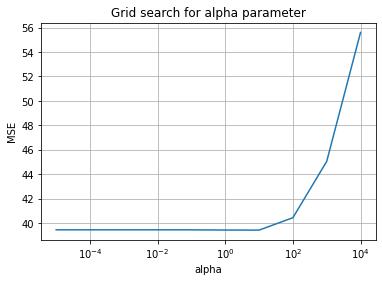

In [ ]:
import matplotlib.pyplot as plt

# mostramos gráficamente los resultados
alpha_values_exponents = np.asarray(alpha_values_exponents)
plt.semilogx(np.power(np.ones(alpha_values_exponents.shape)*10, alpha_values_exponents), mse_values)
plt.title('Grid search for alpha parameter')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

Observando esta gráfica, podemos hacernos algunos planteos extra: ¿necesitamos ajustar un poco más el parámetro? ¿en qué rangos se mueven los mejores valores? ¿cuál es el modelo que mejor ajusta los datos, según los de validación? ¿necesitamos hacer random search? ¿cómo interpretamos el valor óptimo del parámetro?

### 6. Test

Ahora que escogimos el mejor modelo, lo que sigue es evaluarlo sobre los datos de test. Para ello, vamos a simplemente predecir los resultados a partir de las features de test, y comparar las predicciones obtenidas con los valores reales de variables que tenemos. La evaluación la realizaremos con MSE, que es la métrica que escogimos para trabajar. Incluiremos también los valores de MSE en los datos de validación para comparar.

In [ ]:
# generamos las predicciones sobre los datos de test
y_hat_test = best_model.predict(dataset['X_test'])

# comparamos las predicciones con los valores esperados usando MSE
mse_test = mse(dataset['y_test'], y_hat_test)

print('MSE on the validation set: {}'.format(best_mse_on_validation))
print('MSE on the test set: {}'.format(mse_test))


MSE on the validation set: 39.413609482747184
MSE on the test set: 24.26299531766248


En general esperamos que el error en los datos de validación sea menor al de los datos de test. ¿Por qué? Porque a los datos de validación los usamos para diseñar el modelo: escogimos el mejor valor de $\alpha$ basándonos en la performance sobre esos datos, con lo cual tenemos ya un sesgo hacia sobreestimar la eficacia real del modelo. Los datos de test, por el contrario, operan como un conjunto totalmente, un conjunto de muestras que podríamos encontrarnos en la vida real, con nuestra aplicación deployada.

### 7. Control de overfitting/underfitting

Algo que siempre debemos hacer cuando trabajamos en machine learning es analizar si nuestros datos tienen o no overfitting/underfitting.

Un modelo con overfitting logró "memorizar" los datos de entrenamiento (ajustar sus parámetros hasta lograr un error muy bajo), a tal punto que cuando se aplica sobre datos nuevos diferentes a los de entrenamiento falla horriblemente.

Un modelo con underfitting es su contraparte: es un modelo con poca capacidad, que no puede aprender nada de los datos de entrenamiento.

Para evaluar underfitting/overfitting necesitamos entrenar el modelo y evaluarlo sobre los datos de entrenamiento y de validación. Si el modelo anda demasiado bien sobre los datos de entrenamiento pero falla horriblemente en los de validación, hay overfitting. Si el modelo anda horriblemente en los datos de entrenamiento, hay underfitting.

El código a continuación evalúa los múltiples modelos posibles de Ridge Regression que podemos obtener para diferentes valores de $\alpha$, evaluándolos tanto sobre los datos de entrenamiento como los de validación. Un buen ejercicio es reconocer cuáles tienen overfitting/underfitting y cuáles no.

In [ ]:
# probamos cada configuración
print('Evaluating overfitting/underfitting')
print('=================')
for k in alpha_values_exponents:
  # calculamos alpha
  current_alpha_try = 10.0**k
  # declaramos el objeto del modelo
  model = Ridge(alpha=current_alpha_try, fit_intercept=True)
  # entrenamos el modelo con los datos de entrenamiento
  model.fit(dataset['X_train'], dataset['y_train'])
  # predecimos con los datos de entrenamiento
  y_hat_train = model.predict(dataset['X_train'])
  # predecimos con los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # calculamos el MSE en ambos casos
  mse_train = mse(dataset['y_train'], y_hat_train)
  mse_val = mse(dataset['y_val'], y_hat_val)
  # imprimimos por pantalla
  print('alpha = {}'.format(current_alpha_try, ))
  print('- MSE training = {}'.format(mse_train))
  print('- MSE validation = {}'.format(mse_val))

Evaluating overfitting/underfitting
alpha = 1e-05
- MSE training = 29.185323102288663
- MSE validation = 39.43839588902205
alpha = 0.0001
- MSE training = 29.185323102320172
- MSE validation = 39.438393850006385
alpha = 0.001
- MSE training = 29.18532310547061
- MSE validation = 39.43837346304556
alpha = 0.01
- MSE training = 29.185323420297415
- MSE validation = 39.43816991279172
alpha = 0.1
- MSE training = 29.18535468780395
- MSE validation = 39.436166114622296
alpha = 1.0
- MSE training = 29.188280601069046
- MSE validation = 39.41908173158365
alpha = 10.0
- MSE training = 29.364248888397697
- MSE validation = 39.413609482747184
alpha = 100.0
- MSE training = 32.4340227860132
- MSE validation = 40.42953903824175
alpha = 1000.0
- MSE training = 48.966691559711705
- MSE validation = 45.04506942899651
alpha = 10000.0
- MSE training = 74.22427864567969
- MSE validation = 55.60639832993125


### 8. Feature selection

A menudo la etapa de model selection involucra, además, elegir el conjunto óptimo de features que nos asegura no estar empleando features irrelevantes.

Existen numerosas formas de hacerlo. Las más usadas son aquellas que explotan [el uso de algún tipo de regularizador que permite descartar automáticamente las más inútiles](https://en.wikipedia.org/wiki/Lasso_(statistics)). Vamos a ver un ejemplo de este tipo de regularizadores más adelante en esta unidad, y en las clases que siguen.

Otra alternativa más sencilla es, nuevamente, seguir un enfoque greedy. El más utilizado es uno conocido como [forward selection](https://towardsdatascience.com/feature-importance-and-forward-feature-selection-752638849962). Podemos entrenar $d$ modelos de una sola de las $d$ features que tenemos disponibles, y evaluar cada uno de ellos en los datos de validación. A partir de su performance en este conjunto, elegimos aquella que mejor anduvo. A continuación, probamos entrenar otros $p-1$ modelos con dos features esta vez, la que ya elegimos como la mejor y otra que utilizaremos de prueba. Nuevamente, evaluamos cada combinación sobre los datos de validación y elegimos el par que mejor funciona. Así, repetimos esta búsqueda hasta tanto agregar nuevas features no mejora la performance. Como resultado, obtendremos un conjunto de menos features en el que a priori descartamos algunas combinaciones que no nos sirven.

¿Es óptimo? No. El óptimo es usar backtracking y explorar todas las posibles combinaciones. ¿Podemos hacerlo? Sí, si tenés tiempo y ganas. En la vida real, con un enfoque greedy estamos bien.

El siguiente código hace feature selection de nuestro modelo utilizando este enfoque. Por simplicidad, fíjense que usamos un valor fijo de $\alpha$. Sin embargo, lo ideal sería que para cada combinación de features probemos todos los valores de $\alpha$, para quedarnos con la combinación más conveniente.

In [ ]:
import sys

model = Ridge(alpha=10, fit_intercept=True)

# inicializamos un arreglo vacío de features seleccionadas
selected_features = np.zeros(dataset['X_train'].shape[1], dtype=np.bool)
# inicializamos dos variables para llevar los MSE
previous_best_mse = sys.maxsize
current_best_mse = sys.maxsize - 1
# y una variable que indique la nueva feature que se va a incorporar
new_feature = None
# recuperamos los nombres de las features
feature_names = np.asarray(list(dataset['feature_labels'].keys()))

# si el error en la iteración anterior fue mayor al nuevo error
while (previous_best_mse > current_best_mse):

  # agregamos la nueva feature al conjunto
  if new_feature:
    selected_features[new_feature] = True
    print('New feature added: {}'.format(feature_names[new_feature]))
    print('New set of features: {}'.format(feature_names[selected_features]))
    print('MSE: {}'.format(current_best_mse))
    print('============================')

  # actualizamos los valores de mejor mse
  previous_best_mse = current_best_mse

  # inicializamos un arreglo para guardar el mse obtenido al probar cada feature
  per_feature_mse = np.ones(selected_features.shape) * sys.maxsize

  # iteramos por cada feature
  for i in range(selected_features.size):

    # si la feature no está seleccionada (no nos interesa volver a probar
    # features de gusto)
    if not (selected_features[i]):

      # seleccionamos la feature a probar
      features_to_try = selected_features.copy()
      features_to_try[i] = True
      # entrenamos el modelo
      model.fit(dataset['X_train'][:,features_to_try], dataset['y_train'])
      # lo evaluamos sobre los datos de validación
      y_hat_val = model.predict(dataset['X_val'][:,features_to_try])
      # registramos su performance
      per_feature_mse[i] = mse(dataset['y_val'], y_hat_val) 

  # recuperamos el valor más bajo de MSE
  new_feature = np.argmin(per_feature_mse)
  current_best_mse = per_feature_mse[new_feature]

# imprimimos el arreglo de mejores features
print('FINAL SET OF FEATURES: {}'.format(feature_names[selected_features]))
print('IGNORED FEATURES: {}'.format(feature_names[np.logical_not(selected_features)]))

New feature added: RM
New set of features: ['RM']
MSE: 51.23110384260224
New feature added: CHAS
New set of features: ['CHAS' 'RM']
MSE: 46.75148230543749
New feature added: AGE
New set of features: ['CHAS' 'RM' 'AGE']
MSE: 41.32904829035105
FINAL SET OF FEATURES: ['CHAS' 'RM' 'AGE']
IGNORED FEATURES: ['CRIM' 'ZN' 'INDUS' 'NOX' 'DIS' 'RAD' 'TAX' 'PTRATIO']


### 9. Cross-validation

Cuando la cantidad de datos es poca o simplemente cuando queremos tener un estimador más robusto de la performance de nuestro método, se recomienda evitar las particiones fijas en training, validation y test y recurrir a una estrategia diferente conocida como validación cruzada o [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

Para ilustrar esta estrategia, lo primero que haremos es descargar un nuevo data set, el [Pima Indians Diabetes Dataset](https://github.com/ignaciorlando/duia-ml-datasets/tree/master/PIMADataset). El mismo cuenta con datos y medidas clínicas de distintos pacientes, y una variable objetivo que indica a quiénes se les manifestará diabetes en 5 años. Esta variable toma dos valores: 0 (no se manifestará diabetes) y 1 (se manifestará). Se trata entonces de un problema de clasificación binaria en el que buscamos determinar la clase de un paciente dados sus datos y medidas clínicas.

In [ ]:
# importamos el paquete para descargar archivos
import wget
from os import path

# establecemos las características del data set
pima_diabetes_dataset = dict()
pima_diabetes_dataset['url'] = 'https://raw.githubusercontent.com/ignaciorlando/duia-ml-datasets/master/PIMADataset/pima-indians-diabetes.csv'
pima_diabetes_dataset['extension'] = '.csv'
pima_diabetes_dataset['filename'] = path.join(datasets_folder, 'pima_diabetes_dataset' + pima_diabetes_dataset['extension']) 
if not path.exists(pima_diabetes_dataset['filename']):  # descargar solamente si no existe
  wget.download(pima_diabetes_dataset['url'], pima_diabetes_dataset['filename'])
  print('Archivo descargado con éxito')
else:
  print('El archivo {} ya existe.'.format(pima_diabetes_dataset['filename']))

El archivo /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/pima_diabetes_dataset.csv ya existe.


Abriremos el archivo como hicimos la clase pasada:

In [ ]:
# abrimos el archivo de igual forma que antes, solo que indicando que el
# delimitador de columnas es la coma
raw_dataset = np.genfromtxt(pima_diabetes_dataset['filename'], delimiter=',')
# verificamos el tamaño de la matriz que abrimos (filas x columnas)
print('Dataset size: {}'.format(raw_dataset.shape))
# imprimimos las primeras 5 filas para ver qué tipo de datos tenemos
print('First 5 rows:')
print(raw_dataset[0:4,:])

Dataset size: (768, 9)
First 5 rows:
[[  6.    148.     72.     35.      0.     33.6     0.627  50.      1.   ]
 [  1.     85.     66.     29.      0.     26.6     0.351  31.      0.   ]
 [  8.    183.     64.      0.      0.     23.3     0.672  32.      1.   ]
 [  1.     89.     66.     23.     94.     28.1     0.167  21.      0.   ]]


Las diferentes features involucradas son:

- Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
- Diastolic blood pressure (mm Hg).
- Triceps skinfold thickness (mm).
- 2-Hour serum insulin (mu U/ml).
- Body mass index (weight in kg/(height in m)^2).
- Diabetes pedigree function.
- Age (years).
- Class variable (0 or 1).

En principio no observamos ninguna feature que parezca indicar algún tipo de bias. Por ende, lo siguiente que tenemos que hacer es separar  la clase (variable objetivo) de las demás columnas (las features). Podemos hacer esto como la clase anterior:

In [ ]:
# recuperamos únicamente las columnas que nos interesa mantener como features
X = raw_dataset[:,0:8]
# y armamos el arreglo de etiquetas
y = raw_dataset[:,8]

# chequeamos los tamaños de nuestros nuevos conjuntos
print('X size: {}'.format(X.shape))
print('y size: {}'.format(y.shape))
# imprimimos las primeras 5 filas
print('First 4 rows from the design matrix:')
print(X[0:4,:])
print('First 4 labels from the labels array:')
print(y[0:4])

X size: (768, 8)
y size: (768,)
First 4 rows from the design matrix:
[[  6.    148.     72.     35.      0.     33.6     0.627  50.   ]
 [  1.     85.     66.     29.      0.     26.6     0.351  31.   ]
 [  8.    183.     64.      0.      0.     23.3     0.672  32.   ]
 [  1.     89.     66.     23.     94.     28.1     0.167  21.   ]]
First 4 labels from the labels array:
[1. 0. 1. 0.]


Si utilizáramos particiones fijas, ahora es el momento de dividir los datos en training, validation y test, y luego estandarizarlos. Utilizando cross-validation, la cosa cambia un poco. Vamos a usar como ejemplo para la evaluación el método de $k$-fold cross-validation, con $k=12$. Este proceso consiste en extraer $k$ particiones disjuntas (o folds) de los datos con $N / k$ muestras cada uno, que utilizaremos como múltiples test sets, y los restantes $N - (N / k)$ datos de cada fold serán divididos en conjuntos de entrenamiento y validación, respectivamente, que utilizaremos para entrenar y ajustar $k$ modelos. En nuestro ejemplo, tendremos 12 folds de test de 64 muestras cada uno, y $768 - 64 = 704$ muestras que tendremos que dividir en training y validation para entrenar y calibrar los modelos que evaluaremos sobre cada fold.

![Fuente: http://qingkaikong.blogspot.com/2017/02/machine-learning-9-more-on-artificial.html](https://raw.githubusercontent.com/qingkaikong/blog/master/2017_05_More_on_applying_ANN/figures/figure_1.jpg)

Lo primero que haremos entonces será construir los folds. Es importante tener en cuenta que los datos no están estandarizados, y que por ende necesitamos hacerlo antes de entrenar cualquier modelo. Para ello hay que tener en cuenta que los estadísticos que vamos a usar (media y desvío) van a tener que estimarse sobre los training sets de cada fold, y no sobre el conjunto de datos global.

El siguiente código ejemplifica la construcción de los folds y la estandarización de los datos:

In [ ]:
# determinamos la cantidad de folds
k = 12
# calculamos el tamaño de cada fold
fold_size = X.shape[0] // k
# y el de los conjuntos de training y validation
training_set_size = round((X.shape[0] - k) * 0.9)

# generamos una lista con los índices y la aleatorizamos
idx = list(range(0,X.shape[0]))
random.shuffle(idx)

# construimos los folds
start = 0             # inicializamos un iterador que marca el comienzo de cada fold
k_fold_structure = [] # inicializamos la estructura donde los iremos guardando 
                      #(una lista de dicts() con cada k-fold)
for i in range(0, k):
  # 
  print('Building fold {}/{}'.format(i+1,k))
  # tomamos las fold_size muestras que irán para test
  X_test = X[idx[start:start+fold_size],:]
  y_test = y[idx[start:start+fold_size]]
  # recuperamos los índices de todas las demás muestras
  if start == 0:
    train_val_idx = idx[start+fold_size:]
  elif (start + fold_size)==X.shape[0]:
    train_val_idx = idx[0:start]
  else:
    train_val_idx = idx[0:start] + idx[start+fold_size:]
  # la permutamos
  random.shuffle(train_val_idx)
  # tomamos el 90% para training y el restante 10% para validation
  X_train = X[train_val_idx[0:training_set_size],:]
  y_train = y[train_val_idx[0:training_set_size]]
  X_val = X[train_val_idx[training_set_size:],:]
  y_val = y[train_val_idx[training_set_size:]]
  # calculamos la media y el desvío de los datos de entrenamiento
  mu = np.mean(X_train, axis=0)
  sigma = np.std(X_train, axis=0)
  # estandarizamos los datos de training, validation y test
  X_train = (X_train - mu) / sigma
  X_val = (X_val - mu) / sigma
  X_test = (X_test - mu) / sigma
  # creamos el fold
  fold = dict()
  fold['X_train'] = X_train
  fold['y_train'] = y_train
  fold['X_val'] = X_val
  fold['y_val'] = y_val
  fold['X_test'] = X_test
  fold['y_test'] = y_test
  k_fold_structure.append(fold)


Building fold 1/12
Building fold 2/12
Building fold 3/12
Building fold 4/12
Building fold 5/12
Building fold 6/12
Building fold 7/12
Building fold 8/12
Building fold 9/12
Building fold 10/12
Building fold 11/12
Building fold 12/12


Ahora que tenemos los folds construidos, podemos aplicar $k$-fold cross-validation. El proceso consiste en los siguientes pasos:

* Por cada $k$ fold del dataset:
1. Entrenar un modelo con una configuración determinada sobre los datos de entrenamiento del fold.
2. Evaluar el modelo sobre los datos de validación del fold.
3. Repetir (1) y (2) utilizando configuraciones alternativas.
4. Seleccionar el modelo con la configuración que mejor haya performado sobre los datos de validación.
5. Evaluar el modelo del punto (4) en el fold de test y registrar la performance.
* Tras recorrer todos los folds, analizar estadísticamente los resultados obtenidos.

Como en todo proceso de evaluación, es necesario contar con una métrica que nos permita chequear la performance del modelo. En este caso, dado que se trata de un problema de clasificación, podemos utilizar una métrica conocida como [Accuracy](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers), que se calcula como:

${\mathit  {ACC}}=({\mathit  {TP}}+{\mathit  {TN}})/(P+N)$

donde $\mathit  {TP}$ es el número de true positives (valores clasificados como parte de la clase 1 y cuyas etiquetas reales son 1), $\mathit  {TN}$ es el número de true negatives (valores clasificados como parte de la clase 0 y cuyas etiquetas reales son 0), $\mathit  {P}$ es la cantidad total de muestras con etiquetas reales 1 y $\mathit  {N}$ la cantidad total de muestras con etiquetas reales 0. También podemos expresar la ecuación en términos de operaciones de conjuntos:

${\mathit  {ACC}} = |y \cap \hat{y}| / |y|$

donde $\cap$ indica la intersección entre los conjuntos $y$ (etiquetas esperadas) y $\hat{y}$ (etiquetas predichas por el modelo), y $| · |$ denota la cardinalidad (cantidad de elementos) de un conjunto. Esta métrica toma valores entre 0 y 1, siendo 0 cuando la intersección es vacía (la predicción no coincide en absoluto con las etiquetas esperadas) y 1 cuando la intersección es igual a $y$ (el modelo predijo todas las muestras correctamente).

Con el siguiente código creamos una función que evalúa accuracy:

In [ ]:
def accuracy(y, y_hat):
  '''
  Implementación de la métrica de Accuracy
  '''

  # calculamos el número de coincidencias
  intersection = np.count_nonzero(y_hat == y)

  return intersection / y.size


Lo siguiente que nos falta es determinar qué modelo queremos probar. En este ejemplo emplearemos un clasificador binario conocido como [regresión logística (o logistic regression)](https://en.wikipedia.org/wiki/Logistic_regression), que veremos más adelante en la unidad de clasificación. Por lo pronto, basta con pensarlo como una caja negra que, dada una muestra, determina la probabilidad de que la misma pertenezca a la clase 1. Al igual que el modelo de regresión lineal, incluye un hiperparámetro $C$ que determina la influencia del regularizador en la función objetivo del clasificador durante el entrenamiento. En este caso $C = 1/\lambda$ (o $1/\alpha$, si usamos la notación que empleamos anteriormente para regresión lineal), con lo cual podemos interpretarlo como el inverso de la fuerza del regularizador. Así, cuanto más grande más se ignorará el término de regularización y menos se ignorará la función de error del clasificador.

El hiperparámetro $C$ requiere un ajuste. De nuevo, utilizaremos valores $10^i$, con $i \in \{-5, -4, ..., 0, ..., 4, 5 \}$. Para obtener el mejor valor posible, lo que haremos será utilizar los datos de validación de cada fold para cuantificar la performance de cada configuración, y seguiremos un proceso de grid search como hicimos anteriormente. Tengamos en cuenta que este proceso se repetirá mientras recorramos cada fold, y no una única vez como al utilizar particiones fijas. Esto incrementará indefectiblemente el costo computacional del entrenamiento.

Pasamos, entonces, a aplicar $k$-fold cross-validation sobre nuestros $k=12$ folds, utilizando un modelo de regresión logística y la métrica de evaluación Accuracy.

In [ ]:
from sklearn.linear_model import LogisticRegression

# inicializamos un arreglo de valores de accuracy
per_fold_accuracy = np.zeros(len(k_fold_structure))

# inicializamos un arreglo de valores del parámetro C
c_values_exponents = np.arange(-5,5,1)
c_values = np.power(np.ones(c_values_exponents.shape) * 10, c_values_exponents)
c_values_voting = np.zeros(c_values.shape)

# vamos a iterar por cada fold
for k in range(0,len(k_fold_structure)):

  print('====================')
  print('Evaluating {}/{} fold'.format(k+1, len(k_fold_structure)))
  print('====================')

  # recuperamos el k-ésimo fold
  fold = k_fold_structure[k]
  # inicializamos un arreglo de performances de validación
  validation_performance = np.zeros(c_values.shape)

  # evaluamos las múltiples configuraciones
  i = 0
  # iteramos por cada valor de C que queremos probar
  for c in c_values:
    # inicializamos el modelo con esa configuración
    model = LogisticRegression(penalty='l2', C=c, solver='liblinear', fit_intercept=True)
    # entrenamos sobre los datos de entrenamiento de este fold
    model.fit(fold['X_train'], fold['y_train'])
    # clasificamos los datos de validación
    y_val_hat = model.predict(fold['X_val'])
    # calculamos el accuracy de estos resultados
    acc = accuracy(fold['y_val'], y_val_hat)
    print('C = {}  ///  Accuracy = {}'.format(c, acc))
    # lo registramos en nuestro arreglo de performances de validation
    validation_performance[i] = acc
    i = i+1

  # buscamos el valor más alto de performance de validación
  idx = np.argmax(validation_performance)
  max_performance = validation_performance[idx]
  # y el valor de C asociado
  best_c_value = c_values[idx]
  # incrementamos el voting para ese valor
  c_values_voting[idx]+=1
  # lo reportamos por pantalla
  print('Best C value: {} (Acc = {})'.format(best_c_value, max_performance))

  # evaluamos el modelo óptimo sobre los datos de test
  model = LogisticRegression(penalty='l2', C=best_c_value, solver='liblinear', fit_intercept=True)
  model.fit(fold['X_train'], fold['y_train'])
  y_test_hat = model.predict(fold['X_test'])
  # calculamos el accuracy de estos resultados
  acc = accuracy(fold['y_test'], y_test_hat)
  # y lo registramos en el arreglo de performances
  per_fold_accuracy[k] = acc
  print('')
  print('Acc on the test set = {}'.format(acc))
  print('')

print('********************************')
print('k-fold cross validation finished!')
print('********************************')
print('C values = 10^k: {}'.format(c_values_exponents))
print('Voting for C values: {}'.format(c_values_voting))
print('Average performance: Acc = {}'.format(np.mean(per_fold_accuracy)))
print('Stdev performance: Acc = {}'.format(np.std(per_fold_accuracy)))

l2_model_performance = per_fold_accuracy

Evaluating 1/12 fold
C = 1e-05  ///  Accuracy = 0.6666666666666666
C = 0.0001  ///  Accuracy = 0.6666666666666666
C = 0.001  ///  Accuracy = 0.7083333333333334
C = 0.01  ///  Accuracy = 0.8333333333333334
C = 0.1  ///  Accuracy = 0.75
C = 1.0  ///  Accuracy = 0.75
C = 10.0  ///  Accuracy = 0.75
C = 100.0  ///  Accuracy = 0.75
C = 1000.0  ///  Accuracy = 0.75
C = 10000.0  ///  Accuracy = 0.75
Best C value: 0.01 (Acc = 0.8333333333333334)

Acc on the test set = 0.859375

Evaluating 2/12 fold
C = 1e-05  ///  Accuracy = 0.7083333333333334
C = 0.0001  ///  Accuracy = 0.7083333333333334
C = 0.001  ///  Accuracy = 0.7083333333333334
C = 0.01  ///  Accuracy = 0.6666666666666666
C = 0.1  ///  Accuracy = 0.6666666666666666
C = 1.0  ///  Accuracy = 0.6666666666666666
C = 10.0  ///  Accuracy = 0.6666666666666666
C = 100.0  ///  Accuracy = 0.6666666666666666
C = 1000.0  ///  Accuracy = 0.6666666666666666
C = 10000.0  ///  Accuracy = 0.6666666666666666
Best C value: 1e-05 (Acc = 0.7083333333333334)


En este caso decidimos interpretar los datos en función de su media y desvío. La media nos dice en promedio qué performance tuvimos a lo largo de todos los folds. El desvío estándar, por otro lado, nos dice qué tan dispersos están esos valores de accuracy: si el desvío es alto, eso significa que para algunos folds la performance es alta y para otros es baja. Existen diversas causas para que ocurra eso: que los datos no sean representativos, que las clases estén desbalanceadas, que los hiperparámetros estudiados requieran mayor análisis o que el modelo no sea el apropiado. A medida que avancemos en las clases veremos cómo diganosticar estos problemas, y cómo resolverlos (o aliviarlos).

Un último punto tiene que ver con cómo deployar un modelo entrenado y evaluado con cross-validation. ¿Qué modelo elegimos? ¿Entrenado en qué fold? ¿Con qué parámetros? En realidad, usualmente lo que se hace es reentrenar el modelo utilizando todo el conjunto de datos existente (no ya los folds, se considera a todo el dataset como una única partición de training). La configuración de hiperparámetros que se elige es la que que hayamos visto como más efectiva en la evaluación por folds, y lo obtenemos registrando el parámetro óptimo seleccionado en cada iteración (como hicimos en el arreglo ```c_values_voting``` en el código anterior) y quedándonos con el que haya sido seleccionado en la mayor cantidad de casos.

### 10. Comparación de modelos

Supongamos ahora que queremos evaluar otro modelo alternativo, y estudiar cuál es los dos es mejor para una aplicación en concreto.
El modelo que estudiaremos es el de regresión logística nuevamente, pero esta vez cambiaremos la estrategia de regularización: en lugar de usar L2 (que es la misma que se utiliza para ridge regression y que penaliza que los pesos se vayan muy altos), utilizaremos L1 (que tiene como efecto conocido intentar que la mayor cantidad posible de pesos sea igual a 0). Veremos más adelante el detalle de cada regularizador, pero ahora quedémonos con que el modelo entrenado con L1 es distinto al entrenado con L2, y queremos saber cuál es mejor.

Para ello, podemos plantear el mismo proceso de k-fold cross-validation que usamos anteriormente. Registraremos la performance en un nuevo arreglo, que utilizaremos para comparar con el arreglo de performance del modelo con L2. El modelo tiene también a $C$ como único hiperparámetro, y su función es idéntica a la del regularizado con L2: determinar el trade-off entre regularización y error de entrenamiento.

Ejecutemos esta secuencia para cuantificar la performance del modelo con L1.

In [ ]:
from sklearn.linear_model import LogisticRegression

# inicializamos un arreglo de valores de accuracy
per_fold_accuracy = np.zeros(len(k_fold_structure))

# inicializamos un arreglo de valores del parámetro C
c_values_exponents = np.arange(-5,5,1)
c_values = np.power(np.ones(c_values_exponents.shape) * 10, c_values_exponents)
c_values_voting = np.zeros(c_values.shape)

# vamos a iterar por cada fold
for k in range(0,len(k_fold_structure)):

  print('====================')
  print('Evaluating {}/{} fold'.format(k+1, len(k_fold_structure)))
  print('====================')

  # recuperamos el k-ésimo fold
  fold = k_fold_structure[k]
  # inicializamos un arreglo de performances de validación
  validation_performance = np.zeros(c_values.shape)

  # evaluamos las múltiples configuraciones
  i = 0
  # iteramos por cada valor de C que queremos probar
  for c in c_values:
    # inicializamos el modelo con esa configuración
    model = LogisticRegression(penalty='l1', C=c, solver='liblinear', fit_intercept=True)
    # entrenamos sobre los datos de entrenamiento de este fold
    model.fit(fold['X_train'], fold['y_train'])
    # clasificamos los datos de validación
    y_val_hat = model.predict(fold['X_val'])
    # calculamos el accuracy de estos resultados
    acc = accuracy(fold['y_val'], y_val_hat)
    print(f'C = {c:2.2e}  ///  Accuracy = {acc:4.3}')
    # lo registramos en nuestro arreglo de performances de validation
    validation_performance[i] = acc
    i = i+1

  # buscamos el valor más alto de performance de validación
  idx = np.argmax(validation_performance)
  max_performance = validation_performance[idx]
  # y el valor de C asociado
  best_c_value = c_values[idx]
  # incrementamos el voting para ese valor
  c_values_voting[idx]+=1
  # lo reportamos por pantalla
  print('Best C value: {} (Acc = {})'.format(best_c_value, max_performance))

  # evaluamos el modelo óptimo sobre los datos de test
  model = LogisticRegression(penalty='l1', C=best_c_value, solver='liblinear', fit_intercept=True)
  model.fit(fold['X_train'], fold['y_train'])
  y_test_hat = model.predict(fold['X_test'])
  # calculamos el accuracy de estos resultados
  acc = accuracy(fold['y_test'], y_test_hat)
  # y lo registramos en el arreglo de performances
  per_fold_accuracy[k] = acc
  print('')
  print('Acc on the test set = {}'.format(acc))
  print('')
  print('')

print('********************************')
print('k-fold cross validation finished!')
print('********************************')
print('Voting for C values: {}'.format(c_values_voting))
print('Average performance: Acc = {}'.format(np.mean(per_fold_accuracy)))
print('Stdev performance: Acc = {}'.format(np.std(per_fold_accuracy)))

l1_model_performance = per_fold_accuracy

Evaluating 1/12 fold
C = 1.00e-05  ///  Accuracy = 0.542
C = 1.00e-04  ///  Accuracy = 0.542
C = 1.00e-03  ///  Accuracy = 0.542
C = 1.00e-02  ///  Accuracy = 0.667
C = 1.00e-01  ///  Accuracy = 0.708
C = 1.00e+00  ///  Accuracy = 0.75
C = 1.00e+01  ///  Accuracy = 0.75
C = 1.00e+02  ///  Accuracy = 0.75
C = 1.00e+03  ///  Accuracy = 0.75
C = 1.00e+04  ///  Accuracy = 0.75
Best C value: 1.0 (Acc = 0.75)

Acc on the test set = 0.828125


Evaluating 2/12 fold
C = 1.00e-05  ///  Accuracy = 0.583
C = 1.00e-04  ///  Accuracy = 0.583
C = 1.00e-03  ///  Accuracy = 0.583
C = 1.00e-02  ///  Accuracy = 0.542
C = 1.00e-01  ///  Accuracy = 0.667
C = 1.00e+00  ///  Accuracy = 0.667
C = 1.00e+01  ///  Accuracy = 0.667
C = 1.00e+02  ///  Accuracy = 0.667
C = 1.00e+03  ///  Accuracy = 0.667
C = 1.00e+04  ///  Accuracy = 0.667
Best C value: 0.1 (Acc = 0.6666666666666666)

Acc on the test set = 0.828125


Evaluating 3/12 fold
C = 1.00e-05  ///  Accuracy = 0.625
C = 1.00e-04  ///  Accuracy = 0.625
C = 1.

Podemos comparar las medias y desvíos de cada modelo para decidir cuál es el mejor:

In [ ]:
print('Mean +- standard deviation performance of logistic regression classifiers:')
print('with L2 regularization: {:05.4f} +- {:05.4f}'.format(np.mean(l2_model_performance),
                                                            np.std(l2_model_performance)))
print('with L1 regularization: {:05.4f} +- {:05.4f}'.format(np.mean(l1_model_performance),
                                                            np.std(l1_model_performance)))

Mean +- standard deviation performance of logistic regression classifiers:
with L2 regularization: 0.8294 +- 0.0135
with L1 regularization: 0.8073 +- 0.0527


El accuracy es mejor cuanto más cercano a 1 es, con lo cual podemos decidir qué modelo es el mejor comparando las medias y quedarnos con el que mayor valor tenga. 

El desvío estándar nos permite validar cuál de los modelos tiene resultados más variables entre folds. Al momento de elegir el mejor entre dos modelos con idéntica media, solemos escoger aquel que menos variabilidad entre folds tuvo.

Para terminar, otra forma de comparar modelos es utilizando [boxplots](https://en.wikipedia.org/wiki/Box_plot). En estos gráficos utilizamos una caja por modelo. Cada caja representar la distribución de valores de performance del algoritmo, de forma tal que el borde inferior de la caja representa el cuartil 1, la línea central (naranja) la mediana o cuartil 2 y la línea superior el cuartil 3. Además, se incorporan "bigotes" (whiskers) cuyos bordes inferiores / superiores representan el mínimo y máximo valor del conjunto (cuartil 0 y cuartil 4). Finalmente, algunas librerías agregan círculos para representar outliers (valores extremadamente altos o bajos que no se condicen con la distribución general de los datos). El mejor modelo según un boxplot es aquel cuya caja está más arriba (si la métrica de performance es mejor cuando es alta, como en este caso) y con los bigotes y las cajas lo más pequeñas posibles (menos variabilidad en los datos). 

El siguiente código grafica la performance de cada modelo utilizando boxplots: 

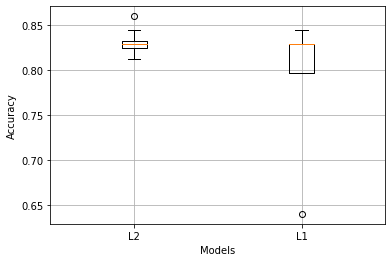

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(np.stack((l2_model_performance, l1_model_performance),axis=1),
            labels=('L2', 'L1'))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Con esto ya tenemos todas las herramientas para, dado un conjunto de datos, poder decidir qué catálogo de soluciones aplicar, cómo entrenar las soluciones usando particiones fijas o cross-validation, cómo ajustar los modelos a partir de datos de validación y cómo determinar cuál es el mejor modelo.

Lo que sigue es empezar a ver uno por uno los modelos de machine learning para cada tipo de problema, y sus ventajas y desventajas. Pero eso toca en la próxima clase :)

### Bonus Track: Algunas instrucciones Python para ser más eficientes

Hasta aquí hemos implementado todos los algoritmos manualmente, para poder entender cómo es que funcionan. La buena noticia es que no vamos a necesitar hacer eso permanentemente. Por suerte, Python nos ofrece varias librerías que nos permiten resolver estas mismas cosas más eficientemente.

El paquete [model_selection de sklearn](https://scikit-learn.org/stable/model_selection.html) ofrece rutinas para hacer cross-validation, calibrar hiperparámetros, métricas para distintos tipos de problemas y para hacer representaciones visuales. Si tienen un rato, chequeen cómo funcionan!